In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')

In [3]:
!pip install torchtext==0.6.0
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [4]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load your dataset from the CSV file
df_small = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

In [6]:
# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

In [7]:

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300, unk_init=torch.Tensor.normal_))
LABEL.build_vocab(train_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:46<00:00, 8619.81it/s]


In [8]:
# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

In [9]:

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
        return self.fc(hidden)

In [10]:
vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 256  # Increase hidden layer dimensions
output_dim = 1
n_layers = 3
bidirectional = True
dropout = 0.5

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adjust learning rate and weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

In [11]:
# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    scheduler,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

In [12]:

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [13]:

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [14]:

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=15,  # Increase the number of epochs
    early_stopping=False,
    patience=4,
)

Epoch: 1, Train Loss: 0.6258, Train Acc: 0.6562, Val Loss: 0.5828, Val Acc: 0.6938
Epoch: 2, Train Loss: 0.5687, Train Acc: 0.7133, Val Loss: 0.5267, Val Acc: 0.7443
Epoch: 3, Train Loss: 0.5274, Train Acc: 0.7431, Val Loss: 0.5039, Val Acc: 0.7636
Epoch: 4, Train Loss: 0.5074, Train Acc: 0.7590, Val Loss: 0.5110, Val Acc: 0.7500
Epoch: 5, Train Loss: 0.4989, Train Acc: 0.7636, Val Loss: 0.4959, Val Acc: 0.7689
Epoch: 6, Train Loss: 0.4889, Train Acc: 0.7729, Val Loss: 0.4893, Val Acc: 0.7726
Epoch: 7, Train Loss: 0.4787, Train Acc: 0.7777, Val Loss: 0.4982, Val Acc: 0.7713
Epoch: 8, Train Loss: 0.4684, Train Acc: 0.7841, Val Loss: 0.4844, Val Acc: 0.7709
Epoch: 9, Train Loss: 0.4618, Train Acc: 0.7878, Val Loss: 0.4877, Val Acc: 0.7753
Epoch: 10, Train Loss: 0.4597, Train Acc: 0.7913, Val Loss: 0.4833, Val Acc: 0.7709
Epoch: 11, Train Loss: 0.4529, Train Acc: 0.7929, Val Loss: 0.4876, Val Acc: 0.7793
Epoch: 12, Train Loss: 0.4481, Train Acc: 0.8005, Val Loss: 0.4891, Val Acc: 0.7789
E

([0.6258108954429626,
  0.5686689061522484,
  0.5274493420918782,
  0.5073837298403183,
  0.4988755867977937,
  0.48891683625181515,
  0.4787037897010644,
  0.4683609980593125,
  0.4618074683447679,
  0.45968940514326095,
  0.4528616643945376,
  0.44805779335896173,
  0.4441747514108817,
  0.4417378476460775,
  0.43919259286423523],
 [0.5828291572471882,
  0.5267071861852991,
  0.503878006275664,
  0.5109511680425481,
  0.49593713356459396,
  0.48932861774525743,
  0.49816174511896805,
  0.4843508080440633,
  0.48771264808292086,
  0.48330319213106276,
  0.4875898762269223,
  0.48911520624731447,
  0.4800587805344703,
  0.4826705056302091,
  0.4857717893542127],
 [tensor(0.6562, device='cuda:0'),
  tensor(0.7133, device='cuda:0'),
  tensor(0.7431, device='cuda:0'),
  tensor(0.7590, device='cuda:0'),
  tensor(0.7636, device='cuda:0'),
  tensor(0.7729, device='cuda:0'),
  tensor(0.7777, device='cuda:0'),
  tensor(0.7841, device='cuda:0'),
  tensor(0.7878, device='cuda:0'),
  tensor(0.791

In [15]:
# Test the model
print("Test set results:")
test_loss, test_acc = evaluate_model(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test set results:
Test Loss: 0.4906, Test Acc: 0.7723


Test Loss: 0.4906, Test Accuracy: 0.7723, F1 Score: 0.7803
Confusion Matrix:
[[1104  412]
 [ 271 1213]]


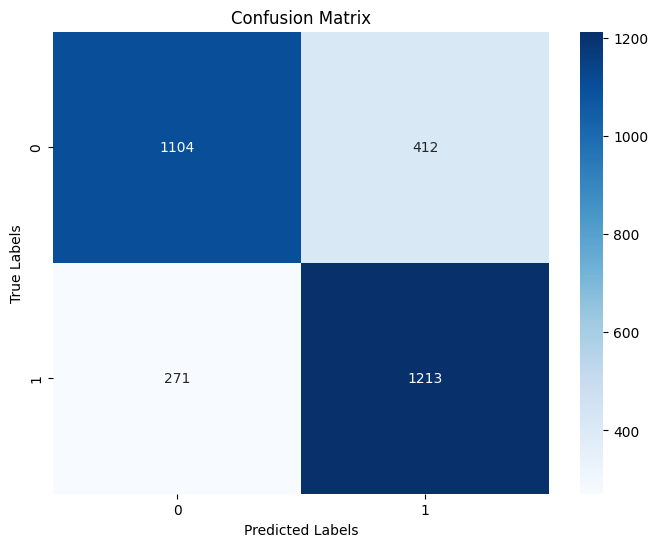

In [16]:

# Define function to calculate F1 score and accuracy
def evaluate_test_set(model, test_iterator, criterion):
    model.eval()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            # Calculate F1 score
            rounded_preds = torch.round(torch.sigmoid(predictions))
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(rounded_preds.cpu().numpy())

    test_loss = epoch_loss / len(test_iterator)
    test_acc = binary_accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))

    f1 = f1_score(true_labels, predicted_labels)

    return test_loss, test_acc, f1, true_labels, predicted_labels

# Evaluate on the test set
test_loss, test_acc, f1, true_labels, predicted_labels = evaluate_test_set(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, F1 Score: {f1:.4f}")

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
